In [946]:
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [947]:
# This notebook basically is me re-doing the previous multi-layer NN classifier to look for an error in the code
# that has came in somewhere along the way

In [948]:
# Very simple neural network that works on classifying things from the wheat and seeds dataset 
"""In general there are X stages we go through to make a fully functional neural network:
1) Initialise the network 
2) Forward Propagate
3) Back Propagate the error
4) Train Network (i.e. update the weights with training data)
5) Predict on test data
"""

'In general there are X stages we go through to make a fully functional neural network:\n1) Initialise the network \n2) Forward Propagate\n3) Back Propagate the error\n4) Train Network (i.e. update the weights with training data)\n5) Predict on test data\n'

In [949]:
def generate_data(num_points, train_perc, plot):
    
    """Inputs : number of points, % of points for training, do you want to plot?
       Outputs: training features, training target, testing features, testing target"""
    
    # define input features
    np.random.seed(1)
    # Creating a random array of x , y points 
    x = np.random.randn(num_points,1)*50
    y = np.random.randn(num_points,1)*50
    
    # Defining a cut off line to split the points into two sections 
    x_line = np.linspace(-150,150,x.size)
    y_line = (1.5*x_line-25)
    # Generating a third column based on the position of the points on the 2D grid
    u = np.zeros((len(x),1))
    u[(1.5*x-25 > y)] = 1
    
    # Concatenating all data
    data = np.concatenate([x,y,u],axis=1)
    
    tr_pt_max = round(num_points*train_perc/100)
    
    # Extracting training data
    train_data = data[0:tr_pt_max,:]
    train_x = train_data[:,(0,1)]
    train_y = train_data[:,2]
    # Extracting test data
    test_data = data[tr_pt_max::,:]
    test_x = test_data[:,(0,1)]
    test_y = test_data[:,2]
        
    # Plotting
    if plot: 
        # Points in group A
        tA = train_x[(train_y==0)] 
        # Points in group B 
        tB = train_x[(train_y==1)]


        # Plotting 
        plt.scatter(test_x[:,0],test_x[:,1],label='Test Data')
        plt.scatter(tA[:,0],tA[:,1],label='Training Points A')
        plt.scatter(tB[:,0],tB[:,1],label='Training Points B')
        plt.plot(x_line,y_line,'b',linewidth=5)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        
    # Reshaping arrays for output
    train_x = train_x.T
    train_y = train_y.T
    
    test_x = test_x.T
    test_y = test_y.T
    
    return train_x, train_y, test_x, test_y

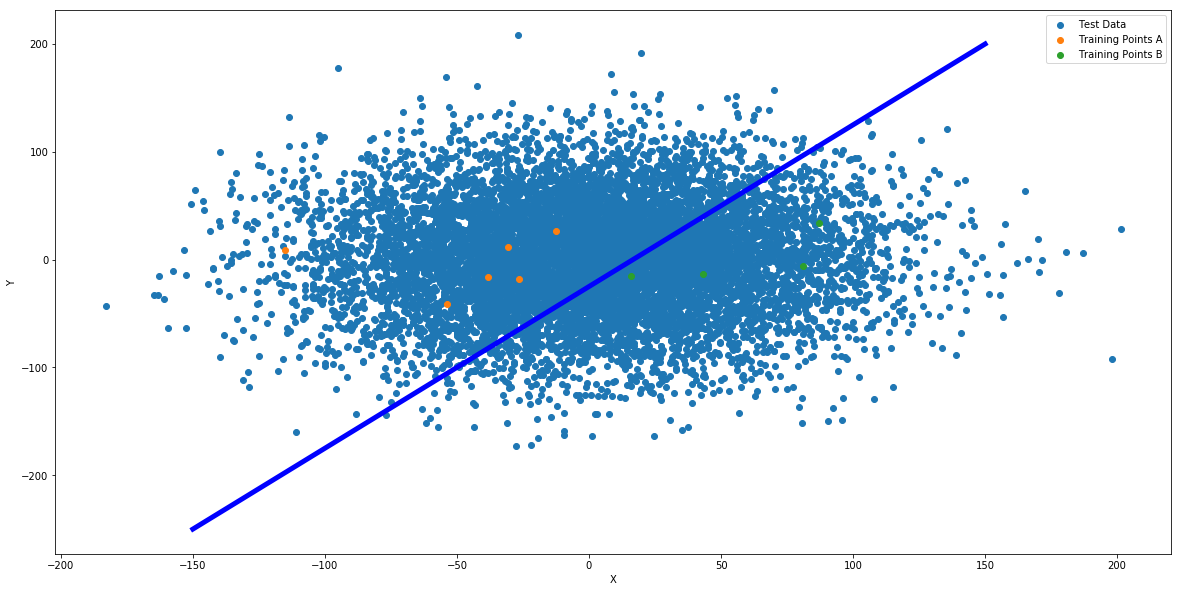

In [950]:
train_x, train_y, test_x, test_y = generate_data(num_points = 10000, train_perc = 0.1, plot=True)

In [951]:
train_x.shape

(2, 10)

In [952]:
# Initialising network 
def init_network(structure):
    
    np.random.seed(1)
    
    """Takes in 4 variables: Number of inputs, number of neurons in hidden layer 1, number of neurons in hidden
       layer 2, number of outputs and creates the weights and bias matrices"""
    # Number of layers
    layers = len(structure)
    # Creating weights and biases lists to be filled in loop 
    weights = []
    biases = []
    
    for i in range(1,layers):
        # Creating weights and biases matrices for each layer
        weights.append([np.random.randn(structure[i], structure[i-1])])
        biases.append([np.random.randn(structure[i],1)])

        # Fixing shapes of arrays in the list 
        weights[i-1] = np.array(weights[i-1]).reshape(structure[i], structure[i-1])
        biases[i-1] = np.array(biases[i-1]).reshape(structure[i],1)

    #print ("WEIGHTS :")
    #print (weights)
    #print ("BIASES : ")
    #print (biases)
    
    return (weights, biases)

In [953]:
# Creating NN structure
n_in = 2 # Number of input Ns
n_hid = 5 # Number of Ns in hidden layer 1
n_hid2 = 3 # Number of Ns in hidden layer 2
n_out = 1 # Number of Ns in output layer

# Structure list for the looping through in FF and BP
structure = [n_in, n_hid, n_hid2, n_out]

In [954]:
weights, biases = init_network(structure)

In [955]:
# Sigmoid activation function 
def sigmoid(X): 
    out = 1/(1+np.exp(-X))
    return out 

In [956]:
# Derivative of sigmoid activation function (used in the gradient descent back propagation)
def sigmoid_der(X):  
    out = sigmoid(X)*(1-sigmoid(X))
    return out

In [957]:
# Feed forward 
def feed_forward(train_x, weights, biases, structure):
    
    """
    Inputs: training features, weights, biases, structure of network
    Outputs: z = raw outputs of network, a = raw outputs passed through activation function"""
    
    layers = len(structure)
    # Creating a and z lists to be filled in loop
    a = []
    z = []
    layer_output = train_x
    
    for i in range(0,layers-1):
        
        # Feed forward through the layer
        z.append(np.dot(weights[i],layer_output)+biases[i])

        # Apply activation _function
        a.append(sigmoid(z[i]))
        layer_output=a[i]
        
    return (z, a)

In [958]:
z, a = feed_forward(train_x, weights, biases, structure)

In [959]:
print (a[-1])

[[0.15711286 0.14084291 0.13994004 0.14078731 0.1571125  0.1385483
  0.16211765 0.14081252 0.14316317 0.15795973]]


In [960]:
# Computing cost using MSE
def compute_cost(y_hat, train_y):
    """
    Inputs: output of final layer of network, target 
    Output: cost"""
    
    num = len(y_hat)
    cost = np.sum(pow(y_hat-train_y,2))/num
    return cost

In [961]:
def back_propagation(train_x, train_y, a, structure, weights, biases):    
    """
    Inputs: training features, training target, activation outputs of layers, network structure, weights, biases
    Outputs: gradients for each layer"""
    
    dW = np.zeros_like(weights)   
    dB = np.zeros_like(biases) 
    dZ = np.zeros_like(weights)

    num = train_x.shape[1]
 
    # Looping backwards to calculate dZ
    for i in reversed(range(0,len(structure)-1)):
        layer_output = a[i]
         
        # If its the last layer in the error in that layer = diff 
        if i == len(structure)-2: 
            # difference between yhat and y 
            dZ[i] = (a[-1] - train_y)*sigmoid_der(layer_output)
            
        # If the layer isnt the last layer the layer error is slightly different 
        else: 
            dZ[i] = (np.dot(weights[i+1].T,dZ[i+1]))* sigmoid_der(layer_output)
            
    # Looping forwards to calculate dW/ dB ###### Need to make this more efficient #######       
    for i in range(0,len(structure)-1):
        
        if i == 0: 
            input_to_use = train_x
        else: 
            input_to_use = a[i-1]

        dW[i] = np.dot(dZ[i],input_to_use.T)

        dB[i] = np.sum(dZ[i],axis=1).reshape(biases[i].shape)
        
          
    return dW, dB

In [962]:
dW, dB = back_propagation(train_x, train_y, a, structure, weights, biases)

In [963]:
def update_params(weights, biases, dW, dB, structure, train_x, a, l_rate):
    """
    Inputs: weights, biases, delta (gradient), structure of network, input features, a (output of each layer)
    , learning rate)
    Outputs: weights, bias"""
    
    weights -= dW*l_rate
    biases -= dB*l_rate
    
    return weights, biases

In [964]:
t_weights, t_biases = update_params(weights, biases, dW, dB, structure, train_x, a, l_rate=0.001)

In [1057]:
def train(train_x, train_y, structure, epoch, l_rate, print_metrics):
    
    """
    Inputs: train_x, train_y, list of nn structure, number of epochs, learning rate
    Outputs: cost, updated weights, updated, biases"""
        
    # Generating weights and biases
    weights, biases = init_network(structure)
    # Metric vectors to fill in the loop
    cost = np.zeros((epoch,1))
    accuracy = np.zeros((epoch, 1))
    for epoch in np.arange(0,epoch):
        # Feed forward 
        z, a = feed_forward(train_x, weights, biases, structure) 
        # Getting output of NN
        y_hat = a[-1]   
        # Calculating cost value for the network 
        cost[epoch] = compute_cost(y_hat, train_y)
        # Calculating network accuracy through the epochs
        # Applying a round to round the values to either 0 or 1 to categorise them (should really be specifying cut
        # off values 0.5 but hey ho
        y_hat_round = np.round(a[-1])
        correct = train_y.reshape(1,len(train_y))[(train_y==y_hat_round)]
        accuracy[epoch] = (len(correct)/len(train_y)*100)        
        # Backpropagation
        dW, dB = back_propagation(train_x, train_y, a, structure, weights, biases)
        # Update params
        weights, biases = update_params(weights, biases, dW, dB, structure, train_x, a, l_rate)
        
        if print_metrics: 
            if epoch % 100 == 0 :
                print ("epoch= "+str(epoch))
                print ("Accuracy" + str(accuracy[epoch]))
                print ("Cost" + str(cost[epoch]))
    return cost, accuracy, weights, biases

In [1143]:
train_x, train_y, test_x, test_y = generate_data(num_points = 10000, train_perc = 40, plot=False)

In [1144]:
# Defining structure of NN 
structure = [2,5,3,1]

In [1145]:
epoch = 500
epochs = range(epoch)
cost, accuracy, t_weights2, t_biases2 = train(train_x, train_y, structure, epoch, l_rate=0.001, print_metrics=False)

Text(0, 0.5, 'Accuracy (%)')

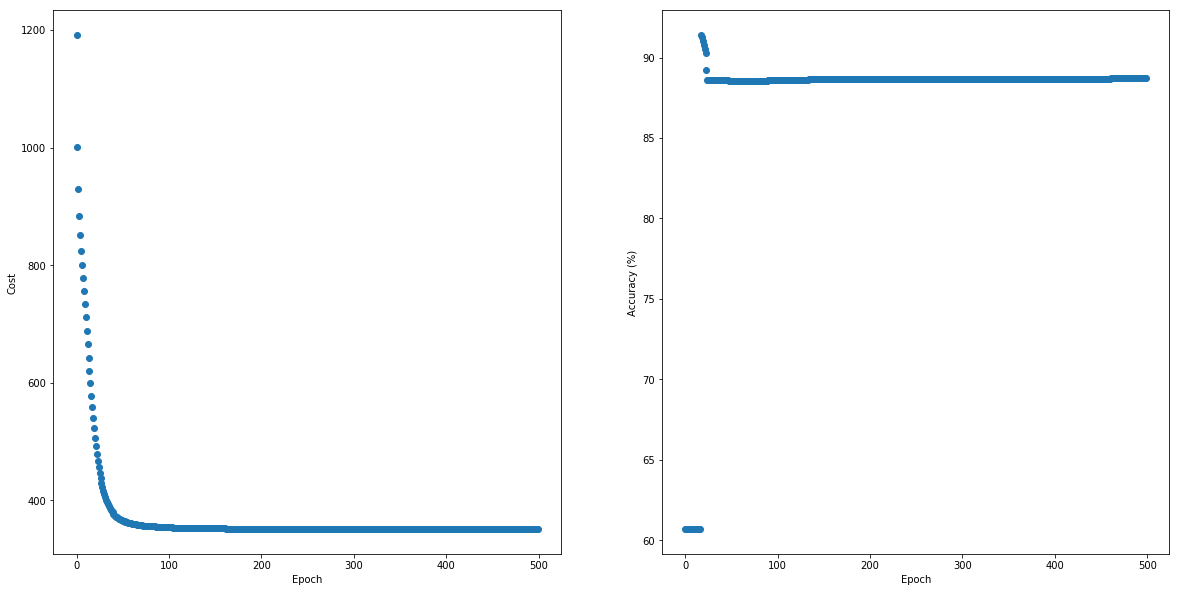

In [1146]:
epochs = range(epoch)
plt.subplot(1,2,1)
plt.scatter(epochs,cost)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.subplot(1,2,2)
plt.scatter(epochs,accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

In [1147]:
accuracy[-1]

array([88.7])

In [1148]:
# Testing NN on test data

In [1185]:
z, a = feed_forward(test_x, t_weights2, t_biases2, structure)

In [1186]:
y_hat = np.round(a[-1])

In [1207]:
test_y_rsh = test_y.reshape(1,6000)

In [1208]:
y_hat.shape

(1, 6000)

In [1209]:
correct = test_y_rsh[(test_y_rsh==y_hat)]

In [1210]:
accuracy = (len(correct)/len(test_y)*100)  

In [1211]:
accuracy

88.58333333333334

In [1212]:
from sklearn import metrics

In [1213]:
y_hat.shape

(1, 6000)

In [1214]:
metrics.f1_score(test_y.reshape(1,len(test_y)), y_hat, average='micro')

0.8714580596734847

In [1215]:
y_hat.shape[1]

6000

In [1217]:
test_y.shape

(6000, 1)

In [1218]:
y_hat.shape

(1, 6000)

In [1219]:
metrics.accuracy_score(test_y_rsh, y_hat, normalize=True)

0.0

In [1221]:
target_names = ['class A', 'class B']
metrics.classification_report(test_y_rsh.T, y_hat.T, target_names = target_names)

'              precision    recall  f1-score   support\n\n     class A       1.00      0.81      0.90      3678\n     class B       0.77      1.00      0.87      2322\n\n    accuracy                           0.89      6000\n   macro avg       0.89      0.91      0.88      6000\nweighted avg       0.91      0.89      0.89      6000\n'

(6000,)
